In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
from torch import nn
from torch import optim

C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# from Triston Grayston
def create_minibatches(states, actions, log_probs, returns, advantages, batch_size):
    n = len(states)

    # shuffle inputs the same way
    indices = np.random.permutation(n)
    states = states[indices]
    actions = actions[indices]
    log_probs = log_probs[indices]
    returns = returns[indices]
    advantages = advantages[indices]

    for start_ind in range(0, n, batch_size):
        end_ind = min(start_ind + batch_size, n)

        yield (
            states[start_ind:end_ind],
            actions[start_ind:end_ind],
            log_probs[start_ind:end_ind],
            returns[start_ind:end_ind],
            advantages[start_ind:end_ind]
        )


PPO-Clip Loss:

$$
L^{CLIP}(\theta) = \mathbb{E}_t \left[ \min \left( r_t(\theta) \hat{A}_t, \text{clip}\left( r_t(\theta), 1 - \epsilon, 1 + \epsilon \right) \hat{A}_t \right) \right],
$$

where:
- $ r_t(\theta) = \frac{\pi_\theta(a_t | s_t)}{\pi_{\theta_\text{old}}(a_t | s_t)} $ is the probability ratio,
- $ \hat{A}_t $ is the advantage estimate at timestep $ t $,
- $ \epsilon $ is a hyperparameter that controls the clipping range (e.g., $ \epsilon = 0.2 $),
- $ \pi_\theta $ is the policy parameterized by $ \theta $,
- $ \pi_{\theta_\text{old}} $ is the policy from the previous iteration.

Note that we want to maximize this value

In [4]:
def ppo_loss(new_log_probs, old_log_probs, advantages, eps):

    ratios = torch.exp(new_log_probs - old_log_probs) # log probs for numerical stability
    clipped_ratios = torch.clamp(ratios, 1 - eps, 1 + eps)
    min_values = torch.min(ratios * advantages, clipped_ratios * advantages)
    return min_values.mean()


Critic Loss: Standard MSE. Target could be return, bootstrapped (TD), GAE. Also may experiment with clipping critic loss in the future

In [5]:
def mse(values, target_values):
    return (values - target_values).pow(2,).mean()

Generalized Advantage Estimation: A balance between cumulative rewards, and bootstrapping returns.

$$
\hat{A}_t = \sum_{l=0}^\infty (\gamma \tau)^l \delta_{t+l},
$$

where:
- $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$ is the TD residual,
- $\gamma$ is the discount factor,
- $\tau$ is the GAE parameter, controlling the trade-off between bias and variance,
- $V(s)$ is the value function estimate for state $s$,
- $r_t$ is the reward at timestep $t$.

GAE can interpolate between high-bias, low-variance ($\tau = 0$) and low-bias, high-variance ($\tau = 1$) advantage estimates.
- $\tau = 0$: $ \hat{A}_t = r_t + \gamma V(s_{t+1}) - V(s_t) $, the TD residual
- $\tau = 1$: $ \sum_{l=0}^\infty (\gamma)^l r_{t+l} - V(s_t) $, the discounted Monte Carlo update

Iterative GAE:

$$
\hat{A}_t = \delta_{t} + \gamma \tau \hat{A}_{t+1}
$$

In [6]:
# given rewards of each state in a trajectory
# returns gae and return
# gamma = discount hyperparameter
# tau = gae hyperparameter (called lambda in gae paper, but can't call var lambda)
def get_gae_and_returns(rewards, values, gamma, tau):

    # assuming gae and ret of time T + 1 is 0.
    # Theoretically probably not correct (idk about gae). Also probably doesn't matter
    gae = 0
    ret = 0

    gaes = torch.zeros(len(rewards), dtype=torch.float32)
    rets = torch.zeros(len(rewards), dtype=torch.float32)

    for t in reversed(range(len(rewards))):
        td_res = rewards[t] + gamma * values[t + 1] - values[t] if t + 1 < len(values) else rewards[t] - values[t]
        gae = td_res + gamma * tau * gae
        gaes[t] = gae

        ret = rewards[t] + gamma * ret
        rets[t] = ret

    
    return gaes, rets

Define Models

In [7]:


class ActorModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,2),
            nn.Tanh() # tanh ensures mu is between -1 and 1
        )
    
    # model returns log standard deviation for numerical stability, and to ensure std is positive
    def forward(self, x):
        return self.model(x)


class CriticModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,1) # returns value of input state
        )
    
    def forward(self, x):
        return self.model(x)

In [8]:
# need to track "states", "actions", "log_probs", "values", "returns", "advantages"
# plays agent through one episode
def rollout(env, actor, critic, device):
    state, _ = env.reset()
    terminated, truncated = False, False
    num_steps = 0

    states = []
    actions = []
    log_probs = []
    rewards = []

    while not terminated and not truncated:

        mu, logstd = actor(torch.FloatTensor(state).to(device))
        dist = torch.distributions.Normal(mu * 2, torch.exp(logstd))
        action = dist.sample()
        action = torch.clamp(action, -2, 2)
        log_prob = dist.log_prob(action)

        next_state, reward, terminated, truncated, _ = env.step([action.item()]) # ignore info
        num_steps += 1

        # log data
        rewards.append(reward)
        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)

        state = next_state

    # convert lists to tensors
    states = torch.FloatTensor(np.array(states))
    actions = torch.FloatTensor(actions)
    log_probs = torch.FloatTensor(log_probs)
    rewards = torch.FloatTensor(rewards)

    # get values, returns, and advantages
    values = critic(states)
    advantages, returns = get_gae_and_returns(rewards, values, gamma, tau)

    # normalize advantages and returns
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    # returns = (returns - returns.mean()) / (returns.std() + 1e-8) # normalizing returns breaks everything... Why does it work in Triston's?

    return states, actions, log_probs, rewards, values, advantages, returns

In [43]:
def linear_decay_schedule(start, end, n_steps, cur_step): # varying with entropy coefficient messes with the ppo loss --> not sure about the implications
    threshold = n_steps // 2
    if cur_step < threshold:
        return start
    else:
        n_steps = n_steps - threshold
        cur_step -= threshold
        return ((end - start) / n_steps) * cur_step + start

In [45]:
def train(env, critic, actor, device, eps, num_epochs, entropy_coef, batch_size, lr_actor=1e-3, lr_critic=1e-3):

    critic_losses = []
    actor_losses = []
    undiscounted_returns = []
    entropy_coefs = []

    # Define optimizers for actor and critic
    actor_optimizer = optim.Adam(actor.parameters(), lr=lr_actor)
    critic_optimizer = optim.Adam(critic.parameters(), lr=lr_critic)

    with torch.no_grad():
        next_states, next_actions, next_old_log_probs, next_rewards, next_old_values, next_advantages, next_returns = rollout(env, actor, critic, device)

    for epoch in range(num_epochs):
        states, actions, old_log_probs, rewards, old_values, advantages, returns = next_states, next_actions, next_old_log_probs, next_rewards, next_old_values, next_advantages, next_returns

        # do new rollout before parameter update
        with torch.no_grad():
            next_states, next_actions, next_old_log_probs, next_rewards, next_old_values, next_advantages, next_returns = rollout(env, actor, critic, device)

        for b_states, b_actions, b_old_log_probs, b_returns, b_advantages in create_minibatches(states, actions, old_log_probs, returns, advantages, batch_size):

            # get new log probabilities
            output = actor(b_states)
            mu = output[:,0] * 2
            logstd = output[:,1] # Should try setting constant variance as experiment if stuff isn't working (it didn't help)
            dist = torch.distributions.Normal(mu, torch.exp(logstd))
            b_new_log_probs = dist.log_prob(b_actions)

            # get new values
            b_new_values = critic(b_states)[:,0] # convert to shape [batch_size] from [batch_size, 1] 

            # calculate losses
            entropy = logstd.sum()
            # cur_entropy_coef = linear_decay_schedule(entropy_coef, 0, num_epochs, epoch)
            # entropy_coefs.append(cur_entropy_coef)

            actor_loss = -ppo_loss(b_new_log_probs, b_old_log_probs, b_advantages, eps) - entropy_coef * entropy # negative since we maximize ppo_loss and entropy
            critic_loss = mse(b_new_values, b_returns)

            # Backpropagation for critic
            critic_optimizer.zero_grad()
            critic_loss.backward()
            nn.utils.clip_grad_norm_(critic.parameters(), 5)
            critic_optimizer.step()

            # Backpropagation for actor
            actor_optimizer.zero_grad()
            actor_loss.backward()
            nn.utils.clip_grad_norm_(actor.parameters(), 5)
            actor_optimizer.step()


        # log data
        actor_losses.append(actor_loss.detach())
        critic_losses.append(critic_loss.detach())
        undiscounted_returns.append(rewards.sum())
        # ppo_ratios.append(torch.exp(new_log_probs - old_log_probs).detach().mean())

        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1:02}/{num_epochs:02} | "
                f"Actor Loss: {actor_loss.item():.6f} | "
                f"Critic Loss: {critic_loss.item():.4f} | "
                f"Undiscounted Return: {rewards.sum():.4f}")
    
    """ Plot Results """
    fig, axs = plt.subplots(4, 1, figsize=(10, 12))  # 4 rows, 1 column, adjust size as needed

    # Plot Undiscounted returns
    axs[2].plot(undiscounted_returns, label="Undiscounted Returns", color="red")
    axs[2].set_title("Undiscounted Returns")
    axs[2].set_ylabel("Return")
    axs[2].set_xlabel("Episode")  # Only add x-label on the last plot

    # Plot Actor losses
    axs[0].plot(actor_losses, label="Actor Loss", color="red")
    axs[0].set_title("Actor Loss")
    axs[0].set_ylabel("Loss")
    axs[0].set_xlabel("Episode")  # Only add x-label on the last plot

    # Plot Undiscounted returns
    axs[1].plot(critic_losses, label="Critic Loss", color="red")
    axs[1].set_title("Critic Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Episode")  # Only add x-label on the last plot
    
    # Plot Entropy Coefficient
    axs[3].plot(entropy_coefs, label="Entropy Coefficient", color="red")
    axs[3].set_title("Entropy Coefficient")
    axs[3].set_ylabel("Coefficient")
    axs[3].set_xlabel("Episode")  # Only add x-label on the last plot

    # # Plot PPO ratios
    # axs[3].plot(ppo_ratios, label="PPO Ratios", color="red")
    # axs[3].set_title("PPO Ratios")
    # axs[3].set_ylabel("Ratio")
    # axs[3].set_xlabel("Episode")  # Only add x-label on the last plot

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plots
    plt.show()

In [10]:
env = gym.make("Pendulum-v1", render_mode=None)

Hyperparameters

In [49]:
eps = 0.2 # clipping parameter
tau = 0.95 # gae parameter
gamma = 0.95 # discount parameter for returns

num_epochs = 2000
batch_size = 64

a_lr = 1e-3
c_lr = 1e-3

entropy_coef = 0.01

device = "cpu"

Epoch 01/2000 | Actor Loss: -0.030552 | Critic Loss: 16878.1484 | Undiscounted Return: -1341.3596
Epoch 11/2000 | Actor Loss: 0.708033 | Critic Loss: 16240.5332 | Undiscounted Return: -1259.5774
Epoch 21/2000 | Actor Loss: -0.329988 | Critic Loss: 4652.3594 | Undiscounted Return: -926.6539
Epoch 31/2000 | Actor Loss: -0.164675 | Critic Loss: 5398.4536 | Undiscounted Return: -1055.8204
Epoch 41/2000 | Actor Loss: 0.457055 | Critic Loss: 9708.8184 | Undiscounted Return: -1285.4534
Epoch 51/2000 | Actor Loss: 0.605948 | Critic Loss: 7955.0762 | Undiscounted Return: -1435.2577
Epoch 61/2000 | Actor Loss: -0.367364 | Critic Loss: 5642.9253 | Undiscounted Return: -1438.1929
Epoch 71/2000 | Actor Loss: -0.316116 | Critic Loss: 3360.4119 | Undiscounted Return: -1027.2478
Epoch 81/2000 | Actor Loss: -0.663058 | Critic Loss: 4998.9473 | Undiscounted Return: -1654.4927
Epoch 91/2000 | Actor Loss: -0.091788 | Critic Loss: 3218.2637 | Undiscounted Return: -1315.7435
Epoch 101/2000 | Actor Loss: 0.0

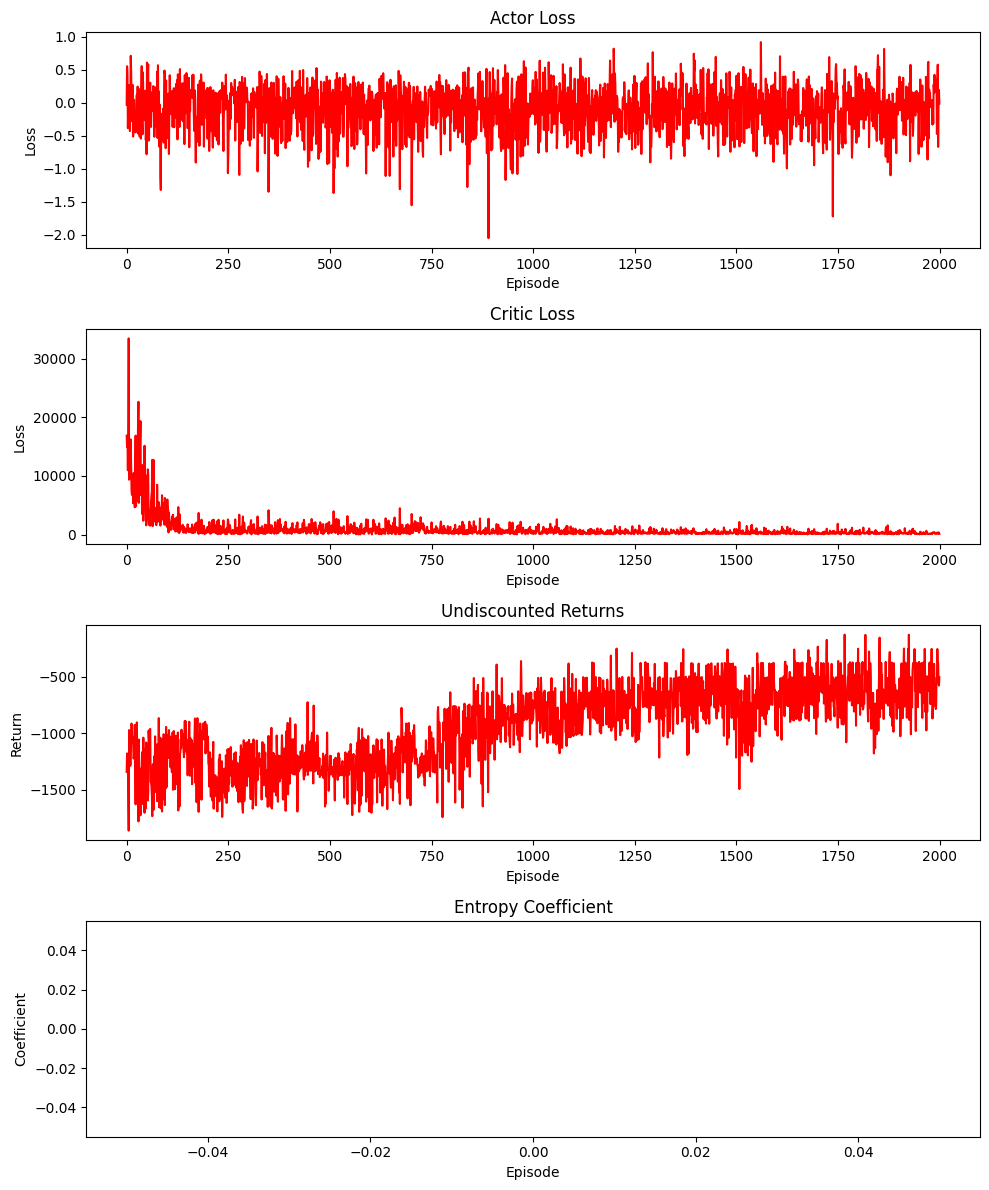

In [50]:
actor_model = ActorModel().to(device)
critic_model = CriticModel().to(device)
train(env, critic_model, actor_model, device, eps, num_epochs, entropy_coef, batch_size, a_lr, c_lr)

In [114]:
# test model

test_env = gym.make("Pendulum-v1", render_mode="human")

state, _ = test_env.reset()

terminated = truncated = False

while not terminated and not truncated:

        mu, logstd = actor_model(torch.FloatTensor(state).to(device))
        action = torch.clamp(mu * 2, -2, 2)

        state, reward, terminated, truncated, _ = test_env.step([action.item()]) # ignore info

        test_env.render()

: 